In [1]:
using Comrade
using Jube
import CairoMakie
using Plots
using StableRNGs
rng = StableRNG(123)

    CondaPkg Found dependencies: /Users/dominicchang/.julia/packages/Comrade/Id3Id/CondaPkg.toml
    CondaPkg Found dependencies: /Users/dominicchang/.julia/packages/PythonCall/dsECZ/CondaPkg.toml
    CondaPkg Found dependencies: /Users/dominicchang/.julia/packages/PythonPlot/f591M/CondaPkg.toml
    CondaPkg Dependencies already up to date


StableRNGs.LehmerRNG(state=0x000000000000000000000000000000f7)

In [2]:
nmax = 3
spin=-0.8 
θo=10*π/180 
θs=π/5
pa=288 
spec_index=0.24
cross_spec_index=-1.46
rpeak=4.69
p1=1.41
p2=5.70
βv=0.97
χ=-2.19
ι=1.31
η=χ+π

o = Jube.AssymptoticObserver(1, θo)
acc = Jube.JuKeBOX(nmax, spin, spec_index, cross_spec_index, rpeak, p1, p2, βv, χ, ι, χ+π)
function raytrace_point(acc, α, β, θs, o)
    direct  = Jube.raytrace(acc, -α, β, θs, o, true)
    indirect = Jube.raytrace(acc, -α, β, θs, o, false)
    return direct .+ indirect
end

raytrace_point(acc, 10.0, 1.0, π/2, o)


4-element StaticArraysCore.SVector{4, Float64} with indices SOneTo(4):
 1.3290123149732326e-5
 4.14911212357724e-6
 1.2625856086659448e-5
 0.0

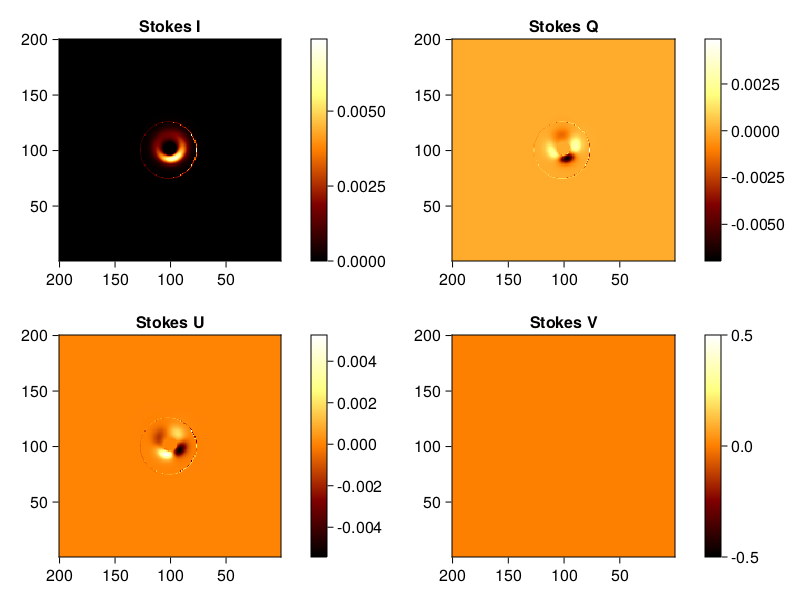

CairoMakie.Screen{IMAGE}


In [3]:
sze = 200
αvals = range(-20, 20, length=sze)
βvals = range(-20, 20, length=sze)
ivals = zeros(sze, sze)
qvals = zeros(sze, sze)
uvals = zeros(sze, sze)
vvals = zeros(sze, sze)

for i in 1:sze
    for j in 1:sze
        stokes = raytrace_point(acc, αvals[i], βvals[j], θs, o)
        ivals[i, j] = stokes[1]
        qvals[i, j] = stokes[2]
        uvals[i, j] = stokes[3]
        vvals[i, j] = stokes[4]

    end
end

fig = CairoMakie.Figure();
ax0 = CairoMakie.Axis(fig[1, 1], aspect=1, title="Stokes I", xreversed=true)
ax1 = CairoMakie.Axis(fig[1, 3], aspect=1, title="Stokes Q", xreversed=true)
ax2 = CairoMakie.Axis(fig[2, 1], aspect=1, title="Stokes U", xreversed=true)
ax3 = CairoMakie.Axis(fig[2, 3], aspect=1, title="Stokes V", xreversed=true)

hm0 = CairoMakie.heatmap!(ax0, ivals, colormap=:afmhot)
CairoMakie.Colorbar(fig[1, 2], hm0)
hm1 = CairoMakie.heatmap!(ax1, qvals, colormap=:afmhot)
CairoMakie.Colorbar(fig[1, 4], hm1)
hm2 = CairoMakie.heatmap!(ax2, uvals, colormap=:afmhot)
CairoMakie.Colorbar(fig[2, 2], hm2)
hm3 = CairoMakie.heatmap!(ax3, vvals, colormap=:afmhot)
CairoMakie.Colorbar(fig[2, 4], hm3)
display(fig)



In [4]:
#using Comrade
using Jube

abstract type AccretionModel <: ComradeBase.AbstractModel end
ComradeBase.visanalytic(::Type{<:AccretionModel}) = ComradeBase.NotAnalytic()
ComradeBase.imanalytic(::Type{<:AccretionModel}) = ComradeBase.IsAnalytic()

struct JKConeModel{B,S,O} <: AccretionModel
    acc_for::B
    acc_bac::B
    s::S
    o::O
end

ComradeBase.isprimitive(::Type{<:JKConeModel}) = ComradeBase.IsPrimitive()


In [5]:
function jukebox(θ, metadata)
    (;m_d, spin, θs, θo, rpeak, pa, p1, p2, χ, ι, βv, spec_index, cross_spec_index) = θ
    (;nmax, cache) = metadata # Cached information that will be used by everymodel
    η = χ + π
    
    acc_for = Jube.JuKeBOX(nmax, spin, spec_index, cross_spec_index, rpeak, p1, p2, βv, χ, ι, η)
    acc_bac = Jube.JuKeBOX(nmax, spin, spec_index, cross_spec_index, rpeak, p1, p2, βv, χ, ι, η+π)
    observer = Jube.AssymptoticObserver(1, θo)
    m = JKConeModel(acc_for, acc_bac, θs, observer)
    mm = modify(m, Stretch(μas2rad(m_d), μas2rad(m_d)), Rotate(pa))
    mimg = Comrade.modelimage(mm, cache, true)
    return mimg
end


jukebox (generic function with 1 method)

In [6]:
function ComradeBase.intensity_point(s::JKConeModel, p)
    α=p.X
    β=p.Y
    direct  = Jube.raytrace(s.acc_for, -α, β, s.s, s.o, true)[1]   + Jube.raytrace(s.acc_bac, -α, β, π-s.s, s.o, true)[1]
    indirect = Jube.raytrace(s.acc_for, -α, β, s.s, s.o, false)[1] + Jube.raytrace(s.acc_bac, -α, β, π-s.s, s.o, false)[1]

    #intensity value and masks
    return direct + indirect
    
end

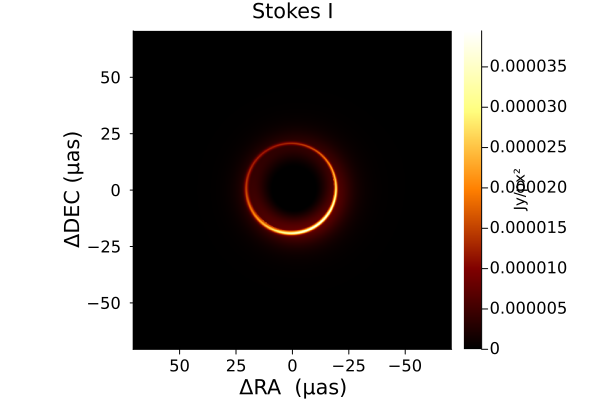

In [7]:
nmax = 1
sze = 200
modelfov = 100
prms1 = (
    m_d = 3.8, 
    spin = -0.8, 
    θo = 10/180*π, 
    θs = π/2, 
    pa = 288, 
    spec_index = 0.24, 
    cross_spec_index = -1.46, 
    rpeak = 4.69, 
    p1 = 1.41, 
    p2 = 5.69, 
    βv = 0.97, 
    χ = -2.19, 
    ι = 1.31
)
cache = create_cache(NFFTAlg(), IntensityMap(zeros(sze, sze), μas2rad(modelfov), μas2rad(modelfov)))
metadata =(nmax=nmax, cache=cache)
Plots.plot(jukebox(prms1, metadata))

In [8]:
load_ehtim()
obs = load_ehtim_uvfits(joinpath(dirname(pathof(Comrade)), "..", "examples", "SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))
obs = obs.add_fractional_noise(0.01)
obs = scan_average(obs.flag_uvdist(uv_min=0.1e9))
dlcamp = extract_lcamp(obs)
dcphase = extract_cphase(obs)
lklhd = RadioLikelihood(jukebox, metadata, dlcamp, dcphase)

using Distributions
prior = (
    m_d = Uniform(1.5, 4.5),
    spin = Uniform(-0.99,-0.01),
    θo =Uniform(1/180*π, 40/180*π),
    θs =Uniform(40/180*π, 90/180*π),
    βv= Uniform(0.0 ,0.90),
    χ = Uniform(-π, 0),
    pa = Uniform(0, 2π),
    ι = Uniform(0, π/2),
    spec_index = Uniform(-3.,3.),
    cross_spec_index = Uniform(-3.,3.),
    rpeak= Uniform(1., 8.),
    p1 = Uniform(0.1, 10),
    p2 = Uniform(1, 10),
)

post = Posterior(lklhd, prior)
cpost = ascube(post)

[ Info: Before homogenizing we have 25 unique times
[ Info: After homogenizing we have 25 unique times
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dominicchang/Documents/ComradeTutorial/.CondaPkg/env/lib/

Comrade.TransformedPosterior{Posterior{RadioLikelihood{Comrade.ModelMetadata{typeof(jukebox), NamedTuple{(:nmax, :cache), Tuple{Int64, Comrade.NUFTCache{NFFTAlg{Float64, AbstractNFFTs.PrecomputeFlags, UInt32}, Nothing, Nothing, DeltaPulse{Float64}, AxisKeys.KeyedArray{Float64, 2, NamedDims.NamedDimsArray{(:X, :Y), Float64, 2, Matrix{Float64}}, GriddedKeys{(:X, :Y), Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}, Nothing, Float64}}}}}}, Tuple{Comrade.ConditionedLikelihood{Comrade.var"#75#76"{Base.Fix2{typeof(logclosure_amplitudes), Comrade.ClosureConfig{Comrade.EHTObservation{Float64, Comrade.EHTVisibilityDatum{Float64}, StructArrays.StructVector{Comrade.EHTVisibilityDatum{Float64}, NamedTuple{(:measurement, :error, :U, :V, :T, :F, :baseline), Tuple{Vector{ComplexF64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Symbol, Symbol}}}}, Int64}, Comrade.EHTArrayConfiguration{Float64, TypedTables.Table{NamedTuple{(:sites, :X, :Y,

In [9]:
using ComradeOptimization
using OptimizationBBO

ndim = dimension(cpost)
f = OptimizationFunction(cpost)
prob = Optimization.OptimizationProblem(f, randn(rng, ndim), nothing, lb=fill(0.0, ndim), ub=fill(1.0, ndim))
sol = solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(); maxiters=5_000)
xopt = transform(cpost, sol)

(m_d = 2.6466201470597013, spin = -0.2684810998927245, θo = 0.4551422567391717, θs = 1.5655204608822673, βv = 0.20635212955698076, χ = -0.36013913786062357, pa = 5.491149193569352, ι = 1.3940872967346933, spec_index = 0.7544363260543925, cross_spec_index = 2.5808589282227734, rpeak = 7.075049568889399, p1 = 5.541171256456698, p2 = 5.331917155246192)

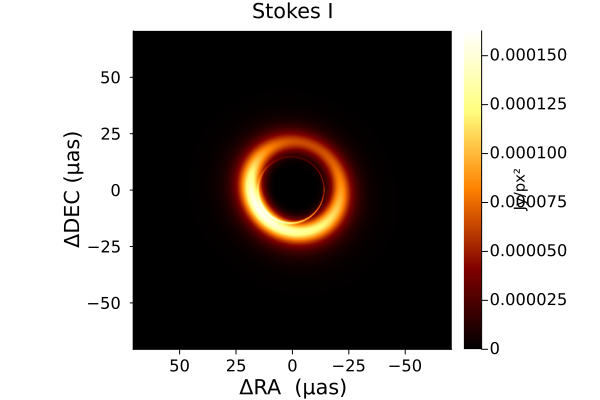

In [10]:
Plots.plot(jukebox(xopt, metadata))

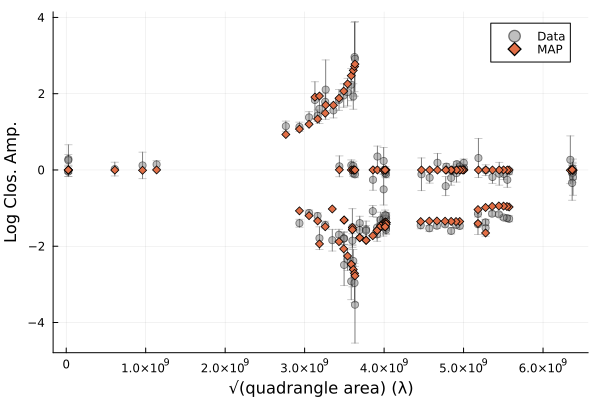

In [11]:
Plots.plot(jukebox(xopt, metadata), dlcamp, label="MAP")